cpu
Training variables: seq_len:5; seed:1
size of seq before reshaping is
torch.Size([5, 28, 28])
Training single layer tPC
Epoch 10, loss 57.04131927490234
Epoch 20, loss 40.56001815795899
Epoch 30, loss 32.01176490783691
Epoch 40, loss 27.2985242843628
Epoch 50, loss 24.324858283996583
Epoch 60, loss 23.10079507827759
Epoch 70, loss 22.153413438796996
Epoch 80, loss 21.780530619621278
Epoch 90, loss 21.11711823940277
Epoch 100, loss 20.825499010086062
Epoch 110, loss 20.798433491587637
Epoch 120, loss 21.027962626516818
Epoch 130, loss 20.793718944489957
Epoch 140, loss 20.55959373936057
Epoch 150, loss 20.95885941199958
Epoch 160, loss 20.538364906050266
Epoch 170, loss 20.692537970375273
Epoch 180, loss 20.787956223264334
Epoch 190, loss 21.01723294290714
Epoch 200, loss 20.444377530273048
training PC complete, time: 0.997328519821167
Training multi layer tPC
Epoch 10, loss 20.906775283813477
Epoch 20, loss 9.99703677892685
Epoch 30, loss 7.080225592851639
Epoch 40, loss 5.72652073

KeyboardInterrupt: 

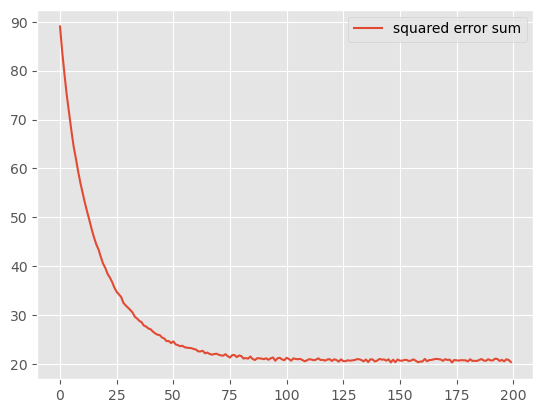

In [2]:
"""
Code for studying MNIST sequences with aliased inputs
"""

import os
import argparse
import json
import time
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.style.use('ggplot')
from src.models import ModernAsymmetricHopfieldNetwork, MultilayertPC, SingleLayertPC, biastPC
from src.utils import *
from src.get_data import *

path = 'aliased'
result_path = os.path.join('./results/', path)
if not os.path.exists(result_path):
    os.makedirs(result_path)

num_path = os.path.join('./results/', path, 'numerical')
if not os.path.exists(num_path):
    os.makedirs(num_path)

fig_path = os.path.join('./results/', path, 'fig')
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

model_path = os.path.join('./results/', path, 'models')
if not os.path.exists(model_path):
    os.makedirs(model_path)

# add parser as varaible of the main class
parser = argparse.ArgumentParser(description='Sequential memories')

parser.add_argument('--seed', type=int, default=[1], nargs='+',
                    help='seed for model init (default: 1); can be multiple, separated by space')
parser.add_argument('--latent-size', type=int, default=480,
                    help='hidden size for training (default: 480)')
parser.add_argument('--input-size', type=int, default=784,
                    help='input size for training (default: 10)')
parser.add_argument('--lr', type=float, default=1e-4,
                    help='learning rate for PC')
parser.add_argument('--epochs', type=int, default=200,
                    help='number of epochs to train (default: 200)')
parser.add_argument('--nonlinearity', type=str, default='tanh',
                    help='nonlinear function used in the model')
parser.add_argument('--mode', type=str, default='train', choices=['train', 'recall', 'PCA'],
                    help='mode of the script: train or recall (just to save time)')
parser.add_argument('--query', type=str, default='offline', choices=['online', 'offline'],
                    help='how you query the recall; online means query with true memory at each time, \
                        offline means query with the predictions')
parser.add_argument('--data-type', type=str, default='continuous', choices=['binary', 'continuous'],
                    help='type of data; note that when HN type is exp or softmax, \
                        this should be always continuous')
# args = parser.parse_args()

args_list = [
    '--seed', '1',  # Overriding the default seed with 42, could also be multiple seeds like '42 100 200'
    '--latent-size', '480',  # Setting latent size as 480 (int)
    '--input-size', '784',  # Setting input size as 784 (int)
    '--lr', '0.0001',  # Setting learning rate as 1e-4 (float), ensure it matches the expected format
    '--epochs', '200',  # Setting number of epochs to 200 (int)
    '--nonlinearity', 'tanh',  # Choosing 'tanh' as the nonlinearity (str), other options might be 'relu', etc.
    '--mode', 'train',  # Setting mode to 'train' (str), other valid options could be 'recall' or 'PCA'
    '--query', 'offline',  # Setting query mode to 'offline' (str), the other option is 'online'
    '--data-type', 'continuous'  # Setting data type to 'continuous' (str), the other option is 'binary'
]
args = parser.parse_args(args_list)

def _extract_latent(model, seq, inf_iters, inf_lr, device):
    seq_len, N = seq.shape
    recall = torch.zeros((seq_len, N)).to(device)
    recall[0] = seq[0].clone().detach()
    prev_z = model.init_hidden(1).to(device)

    # infer the latent of the first image
    x = seq[0].clone().detach()
    model.inference(inf_iters, inf_lr, x, prev_z)
    prev_z = model.z.clone().detach()
    latents = [to_np(prev_z)]

    for k in range(1, seq_len):
        prev_z, _ = model(prev_z)
        latents.append(to_np(prev_z))

    latents = np.concatenate(latents, axis=0)

    # PCA
    pca = PCA(n_components=3)
    transformed_latents = pca.fit_transform(latents)
    
    return transformed_latents

def _plot_recalls(recall, model_name, args):
    seq_len = recall.shape[0]
    fig, ax = plt.subplots(1, seq_len, figsize=(seq_len, 1))
    for j in range(seq_len):
        ax[j].imshow(to_np(recall[j].reshape(28, 28)), cmap='gray_r')
        ax[j].axis('off')
    plt.tight_layout()
    plt.savefig(fig_path + f'/{model_name}_len{seq_len}_query{args.query}', dpi=200)

def _plot_memory(x):
    seq_len = x.shape[0]
    fig, ax = plt.subplots(1, seq_len, figsize=(seq_len, 1))
    for j in range(seq_len):
        ax[j].imshow(to_np(x[j].reshape(28, 28)), cmap='gray_r')
        ax[j].axis('off')
    plt.tight_layout()
    plt.savefig(fig_path + f'/memory_len{seq_len}', dpi=200)

def _plot_PC_loss(loss, seq_len, learn_iters, name):
    # plotting loss for tunning; temporary
    plt.figure()
    plt.plot(loss, label='squared error sum')
    plt.legend()
    plt.savefig(fig_path + f'/{name}_losses_len{seq_len}_iters{learn_iters}')
        
def main(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(device)

    # variables for data and model
    learn_iters = args.epochs
    learn_lr = args.lr
    latent_size = args.latent_size
    input_size = args.input_size
    seed = args.seed
    mode = args.mode
    nonlin = args.nonlinearity

    # inference variables: no need to tune too much
    inf_iters = 100
    inf_lr = 1e-2

    MSEs = []
    seq_len = 5

    print(f'Training variables: seq_len:{seq_len}; seed:{seed}')

    # load data
    seq = load_aliased_mnist(seed).to(device)
    print('size of seq before reshaping is')
    print(seq.shape)
    seq = seq.reshape((seq_len, input_size)) # seq_lenx784
    
    # singlelayer PC
    spc = SingleLayertPC(input_size, nonlin=nonlin).to(device)
    s_optimizer = torch.optim.Adam(spc.parameters(), lr=learn_lr)

    # multilayer PC
    mpc = MultilayertPC(latent_size, input_size, nonlin=nonlin).to(device)
    m_optimizer = torch.optim.Adam(mpc.parameters(), lr=learn_lr)

    # MCHN 
    hn = ModernAsymmetricHopfieldNetwork(input_size, sep='softmax', beta=5).to(device)

    if mode == 'train':
        # train sPC
        print('Training single layer tPC')
        sPC_losses = train_singlelayer_tPC(spc, s_optimizer, seq, learn_iters, device)
        torch.save(spc.state_dict(), os.path.join(model_path, f'sPC_len{seq_len}_seed{seed}.pt'))
        _plot_PC_loss(sPC_losses, seq_len, learn_iters, "spc")

        # train mPC
        print('Training multi layer tPC')
        mPC_losses = train_multilayer_tPC(mpc, m_optimizer, seq, learn_iters, inf_iters, inf_lr, device)
        torch.save(mpc.state_dict(), os.path.join(model_path, f'mPC_len{seq_len}_seed{seed}.pt'))
        _plot_PC_loss(mPC_losses, seq_len, learn_iters, "mpc")
    
    elif mode == 'recall':
        # spc
        spc.load_state_dict(torch.load(os.path.join(model_path, f'sPC_len{seq_len}_seed{seed}.pt'), 
                                       map_location=torch.device(device)))
        spc.eval()

        # mpc
        mpc.load_state_dict(torch.load(os.path.join(model_path, f'mPC_len{seq_len}_seed{seed}.pt'), 
                                       map_location=torch.device(device)))
        mpc.eval()

        with torch.no_grad():
            s_recalls = singlelayer_recall(spc, seq, device, args)
            m_recalls = multilayer_recall(mpc, seq, inf_iters, inf_lr, args, device)
            hn_recalls = hn_recall(hn, seq, device, args)

        if seq_len <= 16:
            _plot_recalls(s_recalls, "sPC", args)
            _plot_recalls(m_recalls, "mPC", args)
            _plot_recalls(hn_recalls, "HN", args)
            _plot_memory(seq)

    elif mode == 'PCA':
        # mpc
        mpc.load_state_dict(torch.load(os.path.join(model_path, f'mPC_len{seq_len}_seed{seed}.pt'), 
                                       map_location=torch.device(device)))
        mpc.eval()

        with torch.no_grad():
            pcs = _extract_latent(mpc, seq, inf_iters, inf_lr, device)
        
        fig = plt.figure(figsize=(4, 3))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(pcs[:, 0], pcs[:, 1], pcs[:, 2])
        plt.savefig(fig_path + '/PCA', dpi=150)
            

if __name__ == "__main__":
    for s in args.seed:
        start_time = time.time()
        args.seed = s
        main(args)
        print(f'{args.mode} finishes, total time elapsed:{time.time() - start_time}')
